<a href="https://colab.research.google.com/github/ranjith0019/ranjith20/blob/main/Sentiment_Analysis_New_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

##Imports

In [ ]:
#Imports for text cleaning
import string
import re
import nltk

nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('omw-1.4')

from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
# Imports for preprocessing, modeling and evaluation
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV

from sklearn import metrics
from sklearn.tree import plot_tree

from sklearn.linear_model import LogisticRegression
from sklearn import naive_bayes
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


from xgboost import XGBClassifier
from xgboost import plot_importance

import time

In [ ]:
# Imports for visualization
import matplotlib.pyplot as plt
import seaborn as sns

##Load Data & Gather Basic Information

In [ ]:
# Load train dataset into a frame
df_train = pd.read_csv('/content/train.csv',encoding='latin1');
df_train.head(10)

,textID,text,selected_text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²)
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,morning,0-20,Afghanistan,38928346,652860.0,60
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,noon,21-30,Albania,2877797,27400.0,105
2,088c60f138,my boss is bullying me...,bullying me,negative,night,31-45,Algeria,43851044,2381740.0,18
3,9642c003ef,what interview! leave me alone,leave me alone,negative,morning,46-60,Andorra,77265,470.0,164
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,noon,60-70,Angola,32866272,1246700.0,26
5,28b57f3990,http://www.dothebouncy.com/smf - some shameles...,http://www.dothebouncy.com/smf - some shameles...,neutral,night,70-100,Antigua and Barbuda,97929,440.0,223
6,6e0c6d75b1,2am feedings for the baby are fun when he is a...,fun,positive,morning,0-20,Argentina,45195774,2736690.0,17
7,50e14c0bb8,Soooo high,Soooo high,neutral,noon,21-30,Armenia,2963243,28470.0,104
8,e050245fbd,Both of you,Both of you,neutral,night,31-45,Australia,25499884,7682300.0,3
9,fc2cbefa9d,Journey!? Wow... u just became cooler. hehe....,Wow... u just became cooler.,positive,morning,46-60,Austria,9006398,82400.0,109


In [ ]:
# Load test dataset into a frame
df_test = pd.read_csv('/content/test.csv',encoding='latin1');
df_test.head(10)

,textID,text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²)
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral,morning,0-20,Afghanistan,38928346.0,652860.0,60.0
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive,noon,21-30,Albania,2877797.0,27400.0,105.0
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative,night,31-45,Algeria,43851044.0,2381740.0,18.0
3,01082688c6,happy bday!,positive,morning,46-60,Andorra,77265.0,470.0,164.0
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive,noon,60-70,Angola,32866272.0,1246700.0,26.0
5,726e501993,that`s great!! weee!! visitors!,positive,night,70-100,Antigua and Barbuda,97929.0,440.0,223.0
6,261932614e,I THINK EVERYONE HATES ME ON HERE lol,negative,morning,0-20,Argentina,45195774.0,2736690.0,17.0
7,afa11da83f,"soooooo wish i could, but im in school and my...",negative,noon,21-30,Armenia,2963243.0,28470.0,104.0
8,e64208b4ef,and within a short time of the last clue all ...,neutral,night,31-45,Australia,25499884.0,7682300.0,3.0
9,37bcad24ca,What did you get? My day is alright.. haven`...,neutral,morning,46-60,Austria,9006398.0,82400.0,109.0


In [ ]:
#Gather basic information about the data
print(df_train.info())
print(df_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   textID            27481 non-null  object 
 1   text              27480 non-null  object 
 2   selected_text     27480 non-null  object 
 3   sentiment         27481 non-null  object 
 4   Time of Tweet     27481 non-null  object 
 5   Age of User       27481 non-null  object 
 6   Country           27481 non-null  object 
 7   Population -2020  27481 non-null  int64  
 8   Land Area (Km²)   27481 non-null  float64
 9   Density (P/Km²)   27481 non-null  int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 2.1+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4815 entries, 0 to 4814
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   textID            3534 non-null   object 
 1   text    

##Data Cleaning & Preprocessing

In [ ]:
#Check for null values
df_train.isnull().sum()

,0
textID,0
text,1
selected_text,1
sentiment,0
Time of Tweet,0
Age of User,0
Country,0
Population -2020,0
Land Area (Km²),0
Density (P/Km²),0


In [ ]:
df_test.isnull().sum()

,0
textID,1281
text,1281
sentiment,1281
Time of Tweet,1281
Age of User,1281
Country,1281
Population -2020,1281
Land Area (Km²),1281
Density (P/Km²),1281


In [ ]:
#Remove rows with missing data in both datasets
df_train.dropna(inplace=True)
df_test.dropna(inplace=True)

In [ ]:
#Check for duplicates in the training dataset
df_train.duplicated().sum()

0

In [ ]:
#Rename columns as needed
df_train.columns= df_train.columns.str.lower()
df_train=df_train.rename(columns={'textid':'text_id','time of tweet':'time_of_tweet','age of user':'age_of_user','population -2020':'population_2020','land area (km²)':'land_area_km2','density (p/km²)':'density_p_km2'})
df_test.columns= df_test.columns.str.lower()
df_test=df_test.rename(columns={'textid':'text_id','time of tweet':'time_of_tweet','age of user':'age_of_user','population -2020':'population_2020','land area (km²)':'land_area_km2','density (p/km²)':'density_p_km2'})

In [ ]:
df_train.head(10)

,text_id,text,selected_text,sentiment,time_of_tweet,age_of_user,country,population_2020,land_area_km2,density_p_km2
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,morning,0-20,Afghanistan,38928346,652860.0,60
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,noon,21-30,Albania,2877797,27400.0,105
2,088c60f138,my boss is bullying me...,bullying me,negative,night,31-45,Algeria,43851044,2381740.0,18
3,9642c003ef,what interview! leave me alone,leave me alone,negative,morning,46-60,Andorra,77265,470.0,164
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,noon,60-70,Angola,32866272,1246700.0,26
5,28b57f3990,http://www.dothebouncy.com/smf - some shameles...,http://www.dothebouncy.com/smf - some shameles...,neutral,night,70-100,Antigua and Barbuda,97929,440.0,223
6,6e0c6d75b1,2am feedings for the baby are fun when he is a...,fun,positive,morning,0-20,Argentina,45195774,2736690.0,17
7,50e14c0bb8,Soooo high,Soooo high,neutral,noon,21-30,Armenia,2963243,28470.0,104
8,e050245fbd,Both of you,Both of you,neutral,night,31-45,Australia,25499884,7682300.0,3
9,fc2cbefa9d,Journey!? Wow... u just became cooler. hehe....,Wow... u just became cooler.,positive,morning,46-60,Austria,9006398,82400.0,109


In [ ]:
# Check if the distribution of sentiment labels in the dataset is imbalanced.
df_train['sentiment'].value_counts()

,count
sentiment,
neutral,11117
positive,8582
negative,7781


Text(0, 0.5, 'Frequency of sentiment')

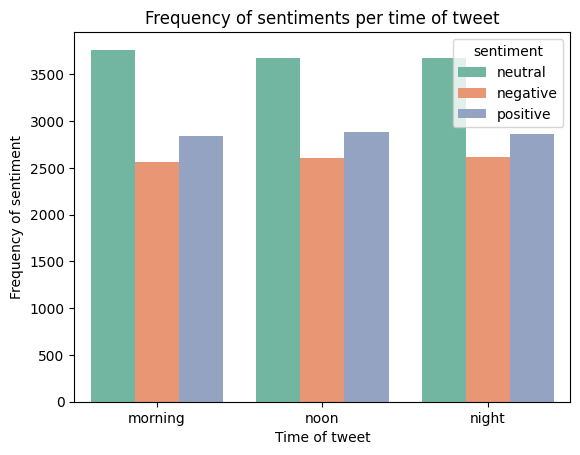

In [ ]:
# Visualizing tweet time distribution with a histogram to determine its influence on sentiment
sns.countplot(data=df_train,x='time_of_tweet',hue='sentiment', palette='Set2')
plt.title("Frequency of sentiments per time of tweet")
plt.xlabel("Time of tweet")
plt.ylabel("Frequency of sentiment")

Text(0, 0.5, 'Frequency of sentiment')

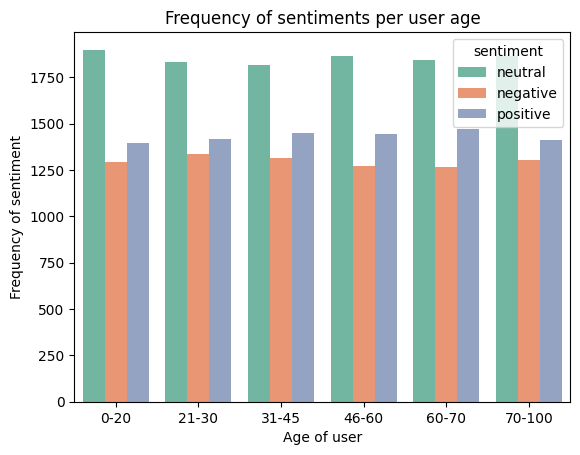

In [ ]:
# Visualizing age-of-user distribution with a histogram to determine its influence on sentiment
sns.countplot(data=df_train,x='age_of_user',hue='sentiment', palette='Set2')
plt.title("Frequency of sentiments per user age")
plt.xlabel("Age of user")
plt.ylabel("Frequency of sentiment")

In [ ]:
# Keep only the 'text' and 'sentiment' columns for further analysis.
df1_train=df_train[['text','sentiment']].copy()

In [ ]:
# Perform cleaning and preprocessing on the 'text' column
def clean_text(text):
    # Remove URLs
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Remove punctuation
    text = re.sub(f'[{string.punctuation}]', '', text)
    # Remove newlines
    text = re.sub(r'\n', '', text)
    # Remove alphanumeric words (words containing digits)
    text = re.sub(r'\b\w*\d\w*\b', '', text)
    # Convert to lowercase
    text = text.lower()
    # Remove remaining non-alphabetic characters (except spaces)
    text = re.sub(r'[^a-z\s]', '', text)
    # Normalize repeated characters (e.g., "soooo" -> "so")
    text = re.sub(r'(.)\1+', r'\1\1', text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = text.split()
    words = [word for word in words if word not in stop_words]

    # Stem words using LancasterStemmer
    stemmer = LancasterStemmer()
    words = [stemmer.stem(word) for word in words]

    # Join words back into a single string
    text = ' '.join(words)

    return text

# Ensure the 'text' column is of string type
df1_train['text'] = df1_train['text'].astype(str)
df_test['text'] = df_test['text'].astype(str)

# Apply the clean_text function and assign it back to the DataFrame
df1_train['text'] = df1_train['text'].apply(clean_text)
df_test['text'] = df_test['text'].apply(clean_text)

In [ ]:
# Display the first 10 rows of the training dataset.
df1_train.head(10)

,text,sentiment
0,"I`d have responded, if I were going",neutral
1,Sooo SAD I will miss you here in San Diego!!!,negative
2,my boss is bullying me...,negative
3,what interview! leave me alone,negative
4,"Sons of ****, why couldn`t they put them on t...",negative
5,http://www.dothebouncy.com/smf - some shameles...,neutral
6,2am feedings for the baby are fun when he is a...,positive
7,Soooo high,neutral
8,Both of you,neutral
9,Journey!? Wow... u just became cooler. hehe....,positive


In [ ]:
# Display the first 10 rows of the testing dataset.
df_test.head(10)

,text_id,text,sentiment,time_of_tweet,age_of_user,country,population_2020,land_area_km2,density_p_km2
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral,morning,0-20,Afghanistan,38928346.0,652860.0,60.0
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive,noon,21-30,Albania,2877797.0,27400.0,105.0
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative,night,31-45,Algeria,43851044.0,2381740.0,18.0
3,01082688c6,happy bday!,positive,morning,46-60,Andorra,77265.0,470.0,164.0
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive,noon,60-70,Angola,32866272.0,1246700.0,26.0
5,726e501993,that`s great!! weee!! visitors!,positive,night,70-100,Antigua and Barbuda,97929.0,440.0,223.0
6,261932614e,I THINK EVERYONE HATES ME ON HERE lol,negative,morning,0-20,Argentina,45195774.0,2736690.0,17.0
7,afa11da83f,"soooooo wish i could, but im in school and my...",negative,noon,21-30,Armenia,2963243.0,28470.0,104.0
8,e64208b4ef,and within a short time of the last clue all ...,neutral,night,31-45,Australia,25499884.0,7682300.0,3.0
9,37bcad24ca,What did you get? My day is alright.. haven`...,neutral,morning,46-60,Austria,9006398.0,82400.0,109.0


In [ ]:
# Select features for training and testing datasets
X_train = df1_train['text']
X_test = df_test['text']
y_train = df1_train['sentiment']
y_test = df_test['sentiment']

In [ ]:
# Apply vectorizer
vectorizer = TfidfVectorizer(ngram_range=(1,2))
XV_train = vectorizer.fit_transform(X_train)
XV_test = vectorizer.transform(X_test)

##Implementation and Analysis of Machine Learning Models

In [ ]:
# Logistic Regression model
print("Training....")
t0=time.time()
clf = LogisticRegression(max_iter = 300).fit(XV_train,y_train)
train_time = time.time()-t0
print(f"train time: {train_time:.3}s")

Training....
train time: 15.3s


In [ ]:
# Predict on test set.
t0=time.time()
y_pred = clf.predict(XV_test)
predict_time = time.time()-t0
print(f"predict time: {predict_time:.3}s")

predict time: 0.00874s


In [ ]:
# Analyze the results
def analyze_results(y_test,y_pred):
    # Get the metrics
    accuracy = metrics.accuracy_score(y_test, y_pred)
    precision =  metrics.precision_score(y_test, y_pred, average='weighted')
    recall = metrics.recall_score(y_test, y_pred, average='weighted')
    f1_score = metrics.f1_score(y_test, y_pred, average='weighted')
    print("Accuracy:", "%.6f" % accuracy)
    print("Precision:", "%.6f" % precision)
    print("Recall:", "%.6f" %  recall)
    print("F1 Score:", "%.6f" %  f1_score)
    print("Classification Report:")
    print(metrics.classification_report(y_test, y_pred))

    # Produce a confusion matrix
    cm = metrics.confusion_matrix(y_test,y_pred)
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf.classes_)
    disp.plot()

    return accuracy, precision, recall, f1_score

Accuracy: 0.707414
Precision: 0.714382
Recall: 0.707414
F1 Score: 0.708449
Classification Report:
              precision    recall  f1-score   support

    negative       0.72      0.65      0.69      1001
     neutral       0.64      0.74      0.69      1430
    positive       0.80      0.72      0.76      1103

    accuracy                           0.71      3534
   macro avg       0.72      0.70      0.71      3534
weighted avg       0.71      0.71      0.71      3534



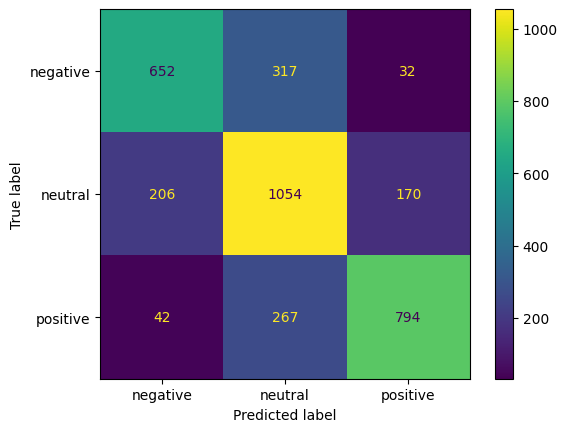

In [ ]:
# Print results
logistic_regression_accuracy, logistic_regression_precision, logistic_regression_recall, logistic_regression_f1_score = analyze_results(y_test,y_pred)

In [ ]:
# Naive Bayes model
nb = naive_bayes.MultinomialNB()
print("Training....")
t0=time.time()
nb.fit(XV_train, y_train)
train_time = time.time()-t0
print(f"train time: {train_time:.3}s")

Training....
train time: 0.356s


In [ ]:
# Predict on test set.
t0=time.time()
y_pred = nb.predict(XV_test)
predict_time = time.time()-t0
print(f"predict time: {predict_time:.3}s")

predict time: 0.00538s


Accuracy: 0.617714
Precision: 0.693585
Recall: 0.617714
F1 Score: 0.602747
Classification Report:
              precision    recall  f1-score   support

    negative       0.80      0.34      0.48      1001
     neutral       0.52      0.87      0.66      1430
    positive       0.81      0.54      0.65      1103

    accuracy                           0.62      3534
   macro avg       0.71      0.58      0.59      3534
weighted avg       0.69      0.62      0.60      3534



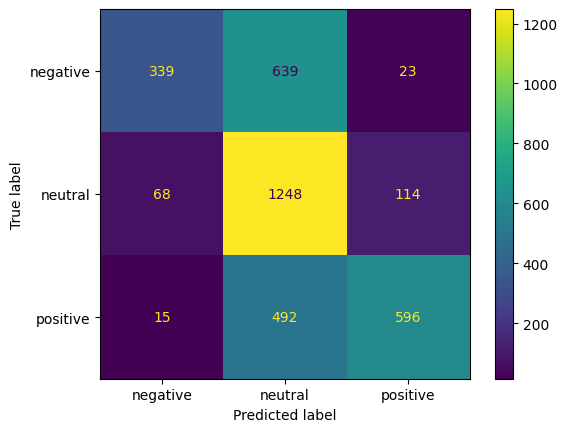

In [ ]:
# Print results
naive_bayes_accuracy, naive_bayes_precision, naive_bayes_recall, naive_bayes_f1_score = analyze_results(y_test,y_pred)

In [ ]:
# Decision Tree model
decision_tree = DecisionTreeClassifier(random_state=0)
print("Training....")
t0=time.time()
decision_tree.fit(XV_train, y_train)
train_time = time.time()-t0
print(f"train time: {train_time:.3}s")

Training....
train time: 69.0s


In [ ]:
# Predict on test set.
t0=time.time()
y_pred = decision_tree.predict(XV_test)
predict_time = time.time()-t0
print(f"predict time: {predict_time:.3}s")

predict time: 0.0347s


Accuracy: 0.657046
Precision: 0.657004
Recall: 0.657046
F1 Score: 0.656856
Classification Report:
              precision    recall  f1-score   support

    negative       0.63      0.66      0.64      1001
     neutral       0.64      0.62      0.63      1430
    positive       0.70      0.71      0.70      1103

    accuracy                           0.66      3534
   macro avg       0.66      0.66      0.66      3534
weighted avg       0.66      0.66      0.66      3534



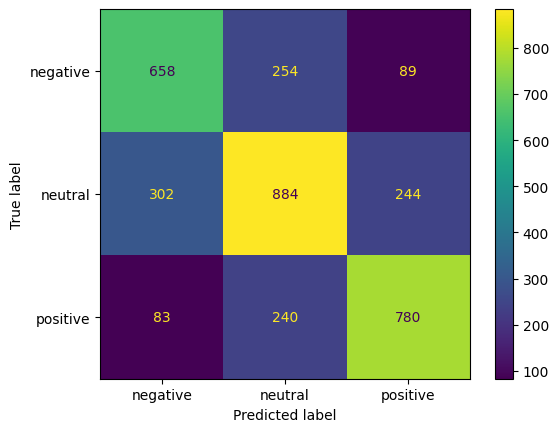

In [ ]:
# Print results
decision_tree_accuracy, decision_tree_precision, decision_tree_recall, decision_tree_f1_score = analyze_results(y_test,y_pred)

In [ ]:
# Random Forest model
cv_params = {'n_estimators' : [50,100],
              'max_depth' : [10,50],
              'min_samples_leaf' : [0.5,1],
              'min_samples_split' : [0.001, 0.01],
              'max_features' : ["sqrt"],
              'max_samples' : [.5,.9]}
rf = RandomForestClassifier(random_state=0)
rf_val = GridSearchCV(rf, cv_params,  refit='f1', n_jobs = -1, verbose = 1)

print("Training....")
t0=time.time()
rf_val.fit(XV_train, y_train)
train_time = time.time()-t0
print(f"train time: {train_time:.3}s")

Training....
Fitting 5 folds for each of 32 candidates, totalling 160 fits


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


train time: 1.2e+03s


In [ ]:
# Obtain the best parameter set identified by GridSearchCV
rf_val.best_params_

{'max_depth': 50,
 'max_features': 'sqrt',
 'max_samples': 0.9,
 'min_samples_leaf': 1,
 'min_samples_split': 0.001,
 'n_estimators': 50}

In [ ]:
# Use optimal parameters from GridSearchCV.
rf_opt = RandomForestClassifier(n_estimators = 50, max_depth = 50,
                                min_samples_leaf = 1, min_samples_split = 0.001,
                                max_features="sqrt", max_samples = 0.9, random_state = 0)

In [ ]:
# Fit the optimal model.
rf_opt.fit(XV_train, y_train)

RandomForestClassifier(max_depth=50, max_samples=0.9, min_samples_split=0.001,
                       n_estimators=50, random_state=0)

In [ ]:
# Predict on test set.
y_pred = rf_opt.predict(XV_test)

Accuracy: 0.539898
Precision: 0.665898
Recall: 0.539898
F1 Score: 0.496330
Classification Report:
              precision    recall  f1-score   support

    negative       0.79      0.19      0.30      1001
     neutral       0.47      0.92      0.62      1430
    positive       0.81      0.37      0.51      1103

    accuracy                           0.54      3534
   macro avg       0.69      0.49      0.48      3534
weighted avg       0.67      0.54      0.50      3534



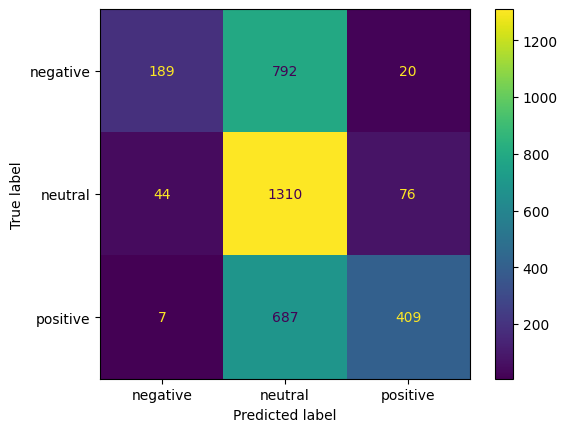

In [ ]:
# Print results
random_forest_accuracy, random_forest_precision, random_forest_recall,random_forest_f1_score = analyze_results(y_test,y_pred)

In [ ]:
#XGBoost model
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
cv_params = {'max_depth': [2, 6],
               'min_child_weight': [1, 5],
              'learning_rate': [0.01, 0.2, 0.3],
               'n_estimators': [5,10,15],
               'subsample': [0.7],
               'colsample_bytree': [0.7]
              }
xgb = XGBClassifier(random_state=0, max_depth=10, n_estimators=100,learning_rate=0.01)
xgb_cv = GridSearchCV(xgb , cv_params,  refit='f1', n_jobs = -1, cv = 5)

print("Training....")
t0=time.time()
xgb_cv.fit(XV_train, y_train_encoded)
train_time = time.time()-t0
print(f"train time: {train_time:.3}s")

Training....
train time: 8.84e+02s


In [ ]:
# Obtain the best parameter set identified by GridSearchCV
xgb_cv.best_params_

{'colsample_bytree': 0.7,
 'learning_rate': 0.3,
 'max_depth': 6,
 'min_child_weight': 1,
 'n_estimators': 15,
 'subsample': 0.7}

In [ ]:
# Use optimal parameters from GridSearchCV.
xgb_opt = XGBClassifier(n_estimators = 15, max_depth = 6, min_child_weight = 1,
                          learning_rate = 0.3, colsample_bytree= 0.7, subsample = 0.7)

In [ ]:
# Fit the optimal model.
xgb_opt.fit(XV_train, y_train_encoded)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.3, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=15, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [ ]:
# Predict on test set.
y_pred = xgb_cv.predict(XV_test)

Accuracy: 0.645161
Precision: 0.685366
Recall: 0.645161
F1 Score: 0.639310
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.43      0.55      1001
           1       0.56      0.82      0.66      1430
           2       0.80      0.61      0.69      1103

    accuracy                           0.65      3534
   macro avg       0.70      0.62      0.63      3534
weighted avg       0.69      0.65      0.64      3534



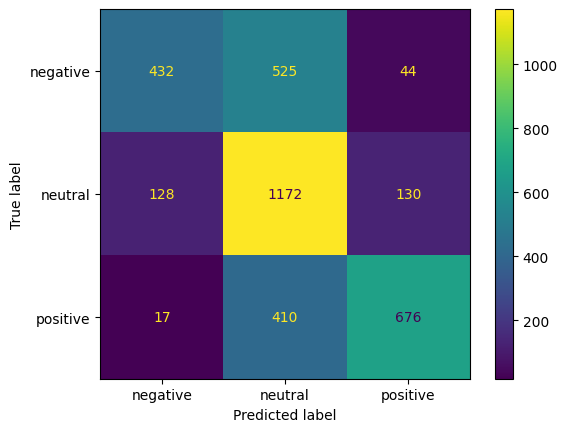

In [ ]:
# Print results
y_test_encoded = label_encoder.fit_transform(y_test)
xgboost_accuracy, xgboost_precision, xgboost_recall,xgboost_f1_score = analyze_results(y_test_encoded,y_pred)

##Summary of Model Results and Conclusion

In [ ]:
# Generate report
table = pd.DataFrame({'Model': ["Logistic Regression","Naive Bayes","Decision Tree", "Random Forest","XGBoost model"],
                        'F1':  [logistic_regression_f1_score, naive_bayes_f1_score, decision_tree_f1_score, random_forest_f1_score, xgboost_f1_score],
                        'Recall':  [logistic_regression_recall, naive_bayes_recall, decision_tree_recall, random_forest_recall, xgboost_recall],
                        'Precision': [logistic_regression_precision, naive_bayes_precision, decision_tree_precision, random_forest_precision, xgboost_precision],
                        'Accuracy': [logistic_regression_accuracy, naive_bayes_accuracy, decision_tree_accuracy, random_forest_accuracy, xgboost_accuracy],
                      }
                    )
table

,Model,F1,Recall,Precision,Accuracy
0,Logistic Regression,0.708094,0.707697,0.710171,0.707697
1,Naive Bayes,0.602747,0.617714,0.693585,0.617714
2,Decision Tree,0.656856,0.657046,0.657004,0.657046
3,Random Forest,0.496330,0.539898,0.665898,0.539898
4,XGBoost model,0.639310,0.645161,0.685366,0.645161


In [ ]:
# Export results to CSV
table.to_csv("Report_text_after_stematization.csv")